In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from scipy.stats import ortho_group, special_ortho_group

In [50]:
%config InlineBackend.figure_format = 'svg'

## Generating random dense vectors from a given similarity matrix

#### Author: Ivana Kajić

In this tutorial we are examining how to generate a set of vectors given a similarity matrix. Similarity matrix $S$ for a set of vectors $X \in \mathbb{R}^{d x n}$ (where $d$ is the dimensionality of a vector and $n$ is the number of vectors) can be computed using a dot product $X^{\top} X $. Matrices of a form $X^{\top} X$ are also known as Gram matrices: $S = X^\top X$.

Gram matrices have certain properties, such as being symmetric $S=S^\top$ and positive-semidefinite (PSD) $x^\top S x \geq 0$ for any $x$. PSD matrices have all nonnegative eigenvalues, which means that not all symmetric matrices are Gram matrices.

For example, given a randomly generated $512 x 512$ symmetric matrix, we are very likely to get some negative eigenvalues:

In [45]:
def random_symmetric_matrix(n):
    tri = .5 * np.eye(n)
    tri[np.triu_indices(n, 1)] = np.around(np.random.uniform(0, 1, size=n**2//2 - n//2), decimals=2)
    return tri + tri.T

In [46]:
d = 512
S_symm = random_symmetric_matrix(d)
print('Generated matrix s is symmetric:', np.allclose(S_symm, S_symm.T))
print('It has all non-negative eigenvalues:', not np.any(np.linalg.eigvalsh(S_symm) < 0))

Generated matrix s is symmetric: True
It has all non-negative eigenvalues: False


Thus, given a matrix S, the fist step is to ensure it is a PSD matrix. We do this by checking whether any of the eigenvalues are negative, and if so, calling nearestPSD function that non-interatively computes the closest PSD matrix for a given S.

In [63]:
def nearPSD(A, epsilon=0.0001):
    # from https://stackoverflow.com/questions/10939213/how-can-i-calculate-the-nearest-positive-semi-definite-matrix
    n = A.shape[0]
    eigval, eigvec = np.linalg.eig(A)
    val = np.matrix(np.maximum(eigval,epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec,vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    return np.array(B*B.T)

In [48]:
S = nearPSD(S_symm, epsilon=0.0001)
print('PSD-matrix S is symmetric:', np.allclose(S, S.T))
print('It has all non-negative eigenvalues:', not np.any(np.linalg.eigvalsh(S) < 0))

print('RMSE: {:.3f}'.format(np.sqrt(mean_squared_error(S_symm.flatten(), S.flatten()))))

PSD-matrix S is symmetric: True
It has all non-negative eigenvalues: True
RMSE: 0.435


This RMSE is actually quite high considering that our similarity values are drawn from $[0, 1]$ interval. This is also reflected in the distribution of values in the resulting PSD matrix which ceases to be uniform: 

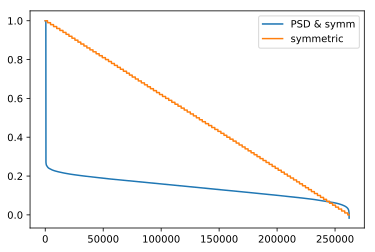

In [52]:
plt.plot(sorted(S.flatten(), reverse=True), label='PSD & symm')
plt.plot(sorted(S_symm.flatten(), reverse=True), label='symmetric')
plt.legend()
plt.show()

SVD decomposition of such a Gram matrix $S$ is $Q \Lambda Q^\top$, where Q is the orthonormal basis and thus 
$Q^\top=Q^{-1}$. This can be written as:

$\begin{equation}
S = Q \Lambda Q^\top = (Q \sqrt \Sigma)(\sqrt {\Sigma^\top}  Q^\top)
 = (Q \sqrt \Sigma) (Q \sqrt \Sigma)^\top
\end{equation}$

And thus $X^\top = Q \sqrt \Sigma$:

In [53]:
q, sval, q_t = np.linalg.svd(S)
sigma = np.sqrt(np.diag(sval))
X = sigma @ q_t

In [54]:
np.allclose(X.T @ X, S, atol=0.001)

True

While we can generate some $X$ given $S$ that reliably reconstructs $S$, a closer look at $X$ and singular values used to compute $X$ show that many values and entries in $X$ are zero:

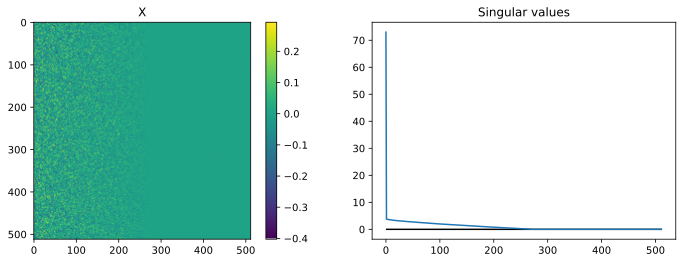

In [58]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(X.T)
plt.title('X')
plt.colorbar()
plt.subplot(122)
plt.plot(sval)
plt.hlines(0, 0, len(sval))
plt.title('Singular values')
plt.show()

For the purpose of generating random dense vectors, we need to modify the way we obtain X. We multiply it by a random orthogonal matrix $U$ following from:

$
\begin{equation}
X^\top X = (U \Sigma V^\top)^\top (U \Sigma V^\top) = V \Sigma^\top U^\top U \Sigma V^\top = V \Sigma^\top \Sigma V^\top = Q \Lambda Q^\top
\end{equation}$

In [60]:
u = ortho_group.rvs(d)
X = u @ sigma @ q_t
print(X.shape)

(512, 512)


True


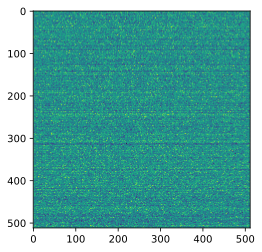

In [61]:
print(np.allclose(X.T @ X, S, atol=0.001))
plt.imshow(X)
plt.show()

**Examining the $d\neq n$ case:** In the previous example we used square sigma matrix, which is only true when $d=n$. Normally, $\Sigma \in \mathbb{R}^{d x n}$, which yields zero columns or zero rows in $\Sigma$, depending on whether $d < n$ or $d > n$. The orthogonal matrix remains $U \in \mathbb{R}^{d x d}$.

In [62]:
def generate_random_vectors(n, dim, S):    
    _, sval, q_t = np.linalg.svd(S)
    sigma = np.zeros((d, n))
    np.fill_diagonal(sigma, np.sqrt(sval))
    u = ortho_group.rvs(d)
    return u @ sigma @ q_t

Proof of concept with a smaller set:

In [64]:
n = 100
S = nearPSD(random_symmetric_matrix(n))

d1, d2, d3 = 64, 100, 512

In [66]:
X1 = generate_random_vectors(n, d1, S)
X2 = generate_random_vectors(n, d2, S)
X3 = generate_random_vectors(n, d3, S)

In [67]:
print(np.allclose(X1.T @ X1, S, atol=0.001))
print(np.allclose(X2.T @ X2, S, atol=0.001))
print(np.allclose(X3.T @ X3, S, atol=0.001))

True
True
True


However, the reconstructed vectors $X$ do a poor job of reconstructing $S$ once $n >> d$ or when $d$ is large. 

In [76]:
d = 128
ns = 2**np.arange(8, 15)

In [77]:
err = []
for n in ns:
    S = nearPSD(random_symmetric_matrix(n))
    X = generate_random_vectors(n, d, S)
    S_est = X.T @ X
    err.append(
        np.sqrt(mean_squared_error(S_est.flatten(), S.flatten()))
    )

Text(0.5, 0, 'Number of vectors')

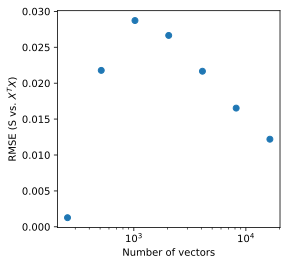

In [82]:
plt.figure(figsize=(4,4))
plt.xscale('log')
plt.plot(ns, err, 'o')
plt.ylabel('RMSE (S vs. $X^T X$)')
plt.xlabel('Number of vectors')

Todo: Explore an accurate representation of S with high dimensionality/large number of vectors.